<a href="https://colab.research.google.com/github/stefphd/bicycle-lnn/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lagragian Neural Network for Bycicle Dynamics

This code identify the bicycle dynamics using a Lagragian Neural Network, with the method proposed in [this paper](https://arxiv.org/abs/2003.04630). This is similar to the DeLaN method (see [this papar](https://arxiv.org/abs/1907.04490)), with the difference that the method is suitable for system involving Lagragian of different forms, including e.g. non-holonomic contraints (as in the bicycle dynamics). The DeLaN method is instead confined to mechanical systems having potential and kinetic energy only (e.g. standard robots).

## Set environment

### Set the Python environment

Python 3.7 is being used for compatibility. Here the Python version is forced to be 3.7 (just installation and setting stuff).

In [1]:
!sudo apt update -y # update repos
!sudo apt install python3.7 # install python 3.7
from IPython.display import clear_output # just to clean the output of Colab
clear_output()
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1 # set installed python3.7 as python3
!sudo apt install python3-pip # install pip
!sudo apt install python3.7-distutils # install distutils according to the installer python version
clear_output()
!python3 --version # check the version

Python 3.7.17


### Install and Import Python Packages

Required Python packages are:

* jax (version 0.1.58) & jaxlib (version 0.1.36)
* numpy (included with jaxlib installation)

In [2]:
!pip install install --upgrade https://storage.googleapis.com/jax-releases/cuda101/jaxlib-0.1.36-cp37-none-linux_x86_64.whl
!pip install --upgrade -q jax==0.1.58

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.4/311.4 KB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.1/38.1 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.5/126.5 KB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.8/262.8 KB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 KB 5.5 MB/s eta 0:00:00


In [2]:
# jax imports
import jax
import jax.numpy as jnp
from jax.example_libraries import stax
from jax.example_libraries import optimizers

# utils
import scipy.io as scio # to import mat files
import numpy as np

# visualization
import matplotlib.pyplot as plt
from functools import partial # reduces args to function by making some subset implicit

### Check GPU
Check if GPU is being used.

In [3]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


## Data elaboration

### Import the data

Experimental bicycle data are imported from a MAT file.

In [9]:
filename = "https://github.com/stefphd/bicycle-lnn/raw/main/data/2022-09-14_FrequencyBand_20kph-test1-filt.mat" # name of the data file (MAT)

!wget {filename} -O "data.mat"
clear_output()
datamat = scio.loadmat("data.mat")

print(datamat.keys()) # print fields of datamat
datamat["time"] = datamat["time"] - datamat["time"][0]; # set initial time to 0
datamat["sample"] = datamat["sample"] - datamat["sample"][0]; # set initial sample to 0
time_step = datamat["time"][1] - datamat["time"][0] # time step
print(f"Sampling frequency: {1/time_step[0]} Hz")


dict_keys(['__header__', '__version__', '__globals__', 'speed', 'distance', 'acc_x', 'acc_y', 'acc_z', 'gyro_x', 'gyro_y', 'gyro_z', 'mag_x', 'mag_y', 'mag_z', 'latitude', 'longitude', 'gps_speed', 'steer_angle', 'steer_rate', 'fork_disp', 'curr_act', 'steer_torque', 'cpu_temp', 'voltage', 'err_state_in', 'curr_ref', 'throttle', 'roll_est', 'yaw_est', 'pos_est_x', 'pos_est_y', 'err_state_out', 'user_data1', 'user_data2', 'user_data3', 'user_data4', 'sample', 'time'])
Sampling frequency: 99.99999999998437 Hz


### Split train and test data

Train and test data are splitted according to a factor.

In [10]:
trainfactor = 0.8 # from 0 to 1 (usually 0.8?), percentage of data used for training (1-train_factor is used for testing)

datalen = len(datamat["time"])
splitlen = round(trainfactor*datalen)

# split data
traindata = dict() # train data
testdata = dict() # test data
for key in datamat.keys():
  if type(datamat[key]) is np.ndarray:
    traindata[key] = datamat[key][:splitlen]
    testdata[key] = datamat[key][splitlen:]

trainsize = len(traindata["time"])
testsize = len(testdata["time"])
trainperc = trainsize / datalen
testperc = testsize / datalen

# print lenghts
print("Train data length: %d (%f%%)" % (trainsize, trainperc))
print("Test data length: %d (%f%%)" % (testsize, testperc))


Train data length: 15041 (0.800011%)
Test data length: 3760 (0.199989%)


### Plot essential data

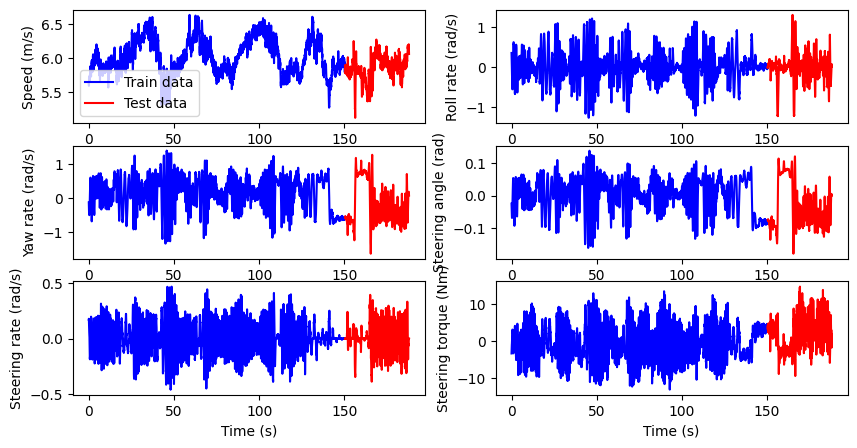

In [11]:
# some plots just to see the data
trainlinespecs = 'b-'
testlinespecs = 'r-'

plt.figure(figsize=[10,5])

plt.subplot(3,2,1) # speed
plt.plot(traindata["time"], traindata["speed"], trainlinespecs, label="Train data")
plt.plot(testdata["time"], testdata["speed"], testlinespecs, label="Test data")
plt.ylabel("Speed (m/s)")
plt.legend()

plt.subplot(3,2,2) # roll rate
plt.plot(traindata["time"], traindata["gyro_x"], trainlinespecs, label="Train data")
plt.plot(testdata["time"], testdata["gyro_x"], testlinespecs, label="Test data")
plt.ylabel("Roll rate (rad/s)")

plt.subplot(3,2,3) # yaw rate
plt.plot(traindata["time"], traindata["gyro_z"], trainlinespecs, label="Train data")
plt.plot(testdata["time"], testdata["gyro_z"], testlinespecs, label="Test data")
plt.ylabel("Yaw rate (rad/s)")

plt.subplot(3,2,4) # steering angle
plt.plot(traindata["time"], traindata["steer_angle"], trainlinespecs, label="Train data")
plt.plot(testdata["time"], testdata["steer_angle"], testlinespecs, label="Test data")
plt.ylabel("Steering angle (rad)")

plt.subplot(3,2,5) # steering angle
plt.plot(traindata["time"], traindata["steer_rate"], trainlinespecs, label="Train data")
plt.plot(testdata["time"], testdata["steer_rate"], testlinespecs, label="Test data")
plt.ylabel("Steering rate (rad/s)")

plt.xlabel("Time (s)")

plt.subplot(3,2,6) # steering torque
plt.plot(traindata["time"], traindata["steer_torque"], trainlinespecs, label="Train data")
plt.plot(testdata["time"], testdata["steer_torque"], testlinespecs, label="Test data")
plt.ylabel("Steering torque (Nm)")

plt.xlabel("Time (s)")

plt.show()

## Build LNN

Here the LNN is built.

In [12]:
# define the neural network model
init_random_params, nn_func = stax.serial(
  stax.Dense(128),
  stax.Softplus,
  stax.Dense(128),
  stax.Softplus,
  stax.Dense(1),
)

# define the lagrangian function
def learned_lagrangian(params):
    def lagrangian(q, qd):
      assert q.shape == (2, )
      state = jnp.concatenate([q, qd])
      return jnp.squeeze(nn_func(params, state), axis=-1)
    return lagrangian

# define eom from lagrangian
def qdd_eom(lagrangian, state, Q, t=None):
  q, qd = jnp.split(state, 2)
  qdd = (jnp.linalg.pinv(jax.hessian(lagrangian, 1)(q, qd))
         @ (jax.grad(lagrangian, 0)(q, qd)
            - jax.jacobian(jax.jacobian(lagrangian, 1), 0)(q, qd) @ qd + Q))
  return jnp.concatenate([qd, qdd])

# runge-kutta step
def rk4_step(f, x, u, t, h):
  k1 = h * f(x, u, t)
  k2 = h * f(x + k1/2, u, t + h/2)
  k3 = h * f(x + k2/2, u, t + h/2)
  k4 = h * f(x + k3, u, t + h)
  return x + 1/6 * (k1 + 2*k2 + 2*k3 + k4)

# define the loss model (MSE, i.e. L2 norm)
@jax.jit
def loss(params, batch, time_step):
  state, Q = batch
  f = partial(qdd_eom, learned_lagrangian(params))
  preds = jax.vmap(partial(rk4_step, f, t=0.0, h=time_step))(state, Q) # integrate [qd, qdd] to obtain [q, qd]
  return jnp.mean(((preds - state)) ** 2)

# Get the state from data dict
def get_state(data):
  return np.concatenate((data["gyro_x"]*0, data["steer_angle"], data["gyro_x"], data["steer_rate"]), axis=1)

# Get the input from data dict
def get_input(data):
  return data["steer_torque"]

## Train the model

Here the model is trained. First define the optimizator used and the update functions, with also some settings.

In [21]:
batch_size = 10
test_every = 2
num_batches = 20

train_losses = []
test_losses = []

xtrain = get_state(traindata)
xtest = get_state(testdata)

tautrain = get_input(traindata)
Qtrain = np.concatenate([tautrain*0, tautrain],axis=1)
tautest = get_input(testdata)
Qtest = np.concatenate([tautest*0, tautest],axis=1)

rng = jax.random.PRNGKey(0)
_, init_params = init_random_params(rng, (-1, 4))

# adam w/ learn rate decay
opt_init, opt_update, get_params = optimizers.adam(
    lambda t: jnp.select([t < batch_size*(num_batches//3),
                          t < batch_size*(2*num_batches//3),
                          t > batch_size*(2*num_batches//3)],
                         [1e-3, 3e-4, 1e-4]))
opt_state = opt_init(init_params)

@jax.jit
def update_timestep(i, opt_state, batch, time_step):
  params = get_params(opt_state)
  return opt_update(i, jax.grad(loss)(params, batch, time_step), opt_state)

Below the training is run.

In [22]:
for iteration in range(batch_size*num_batches + 1):
  if iteration & batch_size == 0:
    params = get_params(opt_state)
    train_loss = loss(params, (xtrain, Qtrain), time_step[0])
    train_losses.append(train_loss)
    test_loss = loss(params, (xtest, Qtest), time_step[0])
    test_losses.append(test_loss)
    if iteration & (batch_size*test_every) == 0:
      print(f"iter={iteration}, train loss={train_loss:.6f}, test_loss={test_loss:.6f}")
  opt_state = update_timestep(iteration, opt_state, (xtrain, Qtrain), time_step)

params = get_params(opt_state)

iter=0, train loss=5696.051758, test_loss=136.165237
iter=1, train loss=3072.924072, test_loss=13.966806
iter=32, train loss=1.805850, test_loss=2.393692
iter=33, train loss=1.794894, test_loss=2.378916
iter=64, train loss=1.696641, test_loss=2.246080
iter=65, train loss=1.696500, test_loss=2.245888
iter=96, train loss=1.695190, test_loss=2.244113
iter=97, train loss=1.695184, test_loss=2.244105
iter=128, train loss=1.695133, test_loss=2.244035
iter=129, train loss=1.695133, test_loss=2.244035
iter=160, train loss=1.695133, test_loss=2.244035
iter=161, train loss=1.695133, test_loss=2.244035
iter=192, train loss=1.695133, test_loss=2.244035
iter=193, train loss=1.695133, test_loss=2.244035


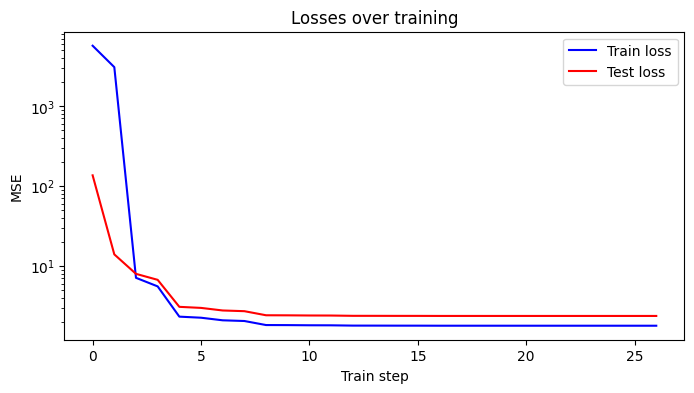

In [20]:
# Plot losses over training
plt.figure(figsize=(8,4))
plt.plot(train_losses, trainlinespecs, label="Train loss")
plt.plot(test_losses, testlinespecs, label="Test loss")
plt.yscale("log")
plt.title("Losses over training")
plt.xlabel("Train step")
plt.ylabel("MSE")
plt.legend()

plt.show()

## Visualize test data

Actual vs. predicted test data